### Naïve Bayes

A continuación vamos a ver ejemplos de Naive Bayes con un ejemplo simple. 

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb
 
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


### ¿Alquilar o comprar?
Vamos a trabajar en una serie de datos referida a viviendas donde deseamos estimar si debemos comprar (1) o arrendar (0) una vivienda. Los datos son: 

ingresos: los ingresos de la familia mensual
gastos comunes: pagos de luz, agua, gas, etc mensual
pago coche: si se está pagando cuota por uno o más coches, y los gastos en combustible, etc al mes.
gastos_otros: compra en supermercado y lo necesario para vivir al mes
ahorros: suma de ahorros dispuestos a usar para la compra de la casa.
vivienda: precio de la vivienda que quiere comprar esa familia
estado civil:

0-soltero
1-casados
2-divorciados
hijos: cantidad de hijos menores y que no trabajan.
trabajo:
0-sin empleo 1-autónomo (freelance)
2-empleado
3-empresario
4-pareja: autónomos
5-pareja: empleados
6-pareja: autónomo y asalariado
7-pareja:empresario y autónomo
8-pareja: empresarios los dos o empresario y empleado
comprar: 0-No comprar 1-Comprar (esta será nuestra columna de salida, para aprender)
Algunos supuestos para el problema formulado:

Está pensado en Euros pero podría ser cualquier otra moneda
No tiene en cuenta ubicación geográfica, cuando sabemos que dependerá mucho los precios de los inmuebles de distintas zonas
Se supone una hipotecario fijo a 30 años con baja tasa de interes.



In [37]:
#from google.colab import files
#uploaded = files.upload()

In [38]:
import pandas as pd
import io

comprar_alquilar = pd.read_csv('comprar_alquilar.csv')
comprar_alquilar.shape[0]

202

In [39]:
comprar_alquilar.head(10)

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar
0,6000,1000,0,600,50000,400000,0,2,2,1
1,6745,944,123,429,43240,636897,1,3,6,0
2,6455,1033,98,795,57463,321779,2,1,8,1
3,7098,1278,15,254,54506,660933,0,0,3,0
4,6167,863,223,520,41512,348932,0,0,3,1
5,5692,911,11,325,50875,360863,1,4,5,1
6,6830,1298,345,309,46761,429812,1,1,5,1
7,6470,1035,39,782,57439,606291,0,0,1,0
8,6251,1250,209,571,50503,291010,0,0,3,1
9,6987,1258,252,245,40611,324098,2,1,7,1


Como podemos ver tenemos distintos tipos de feature, donde no todas son categóricas sino que tambien se cuenta con feature de naturaleza continua. Por lo anterior parece más apropiado utilizar Naive Bayes Gaussiano. 

### Análisis exploratorio de datos

In [40]:
print(comprar_alquilar.groupby('comprar').size())

comprar
0    135
1     67
dtype: int64


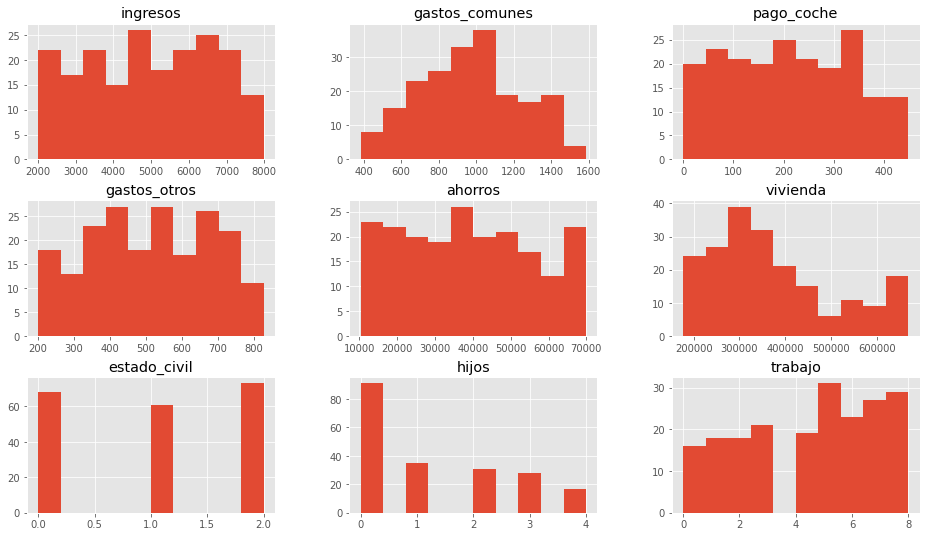

In [41]:
comprar_alquilar.drop(['comprar'], axis=1).hist()
plt.show()

Ahora vamos a mejorar la calidad de los datos. Para esto, generaremos una variable gastos que contenga la suma de gastos comunes, gastos otros y pago por concepto de auto (coche). Además, otra variable se denominará financiar y corresponde a la suma de viviendas y ahorros. 

In [42]:
comprar_alquilar['gastos']=(comprar_alquilar['gastos_comunes']+comprar_alquilar['gastos_otros']+comprar_alquilar['pago_coche'])
comprar_alquilar['financiar']=comprar_alquilar['vivienda']-comprar_alquilar['ahorros']
comprar_alquilar.drop(['gastos_comunes','gastos_otros','pago_coche','ahorros','vivienda'], axis=1).head(10)

,ingresos,estado_civil,hijos,trabajo,comprar,gastos,financiar
0,6000,0,2,2,1,1600,350000
1,6745,1,3,6,0,1496,593657
2,6455,2,1,8,1,1926,264316
3,7098,0,0,3,0,1547,606427
4,6167,0,0,3,1,1606,307420
5,5692,1,4,5,1,1247,309988
6,6830,1,1,5,1,1952,383051
7,6470,0,0,1,0,1856,548852
8,6251,0,0,3,1,2030,240507
9,6987,2,1,7,1,1755,283487


Antes de utilizar el algoritmo veremos un análisis descriptivo de la información. 

In [43]:
reduced = comprar_alquilar.drop(['gastos_comunes','gastos_otros','pago_coche','ahorros','vivienda'], axis=1)
reduced.describe()

,ingresos,estado_civil,hijos,trabajo,comprar,gastos,financiar
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,4958.995050,1.024752,1.232673,4.490099,0.331683,1698.752475,334599.970297
std,1682.862556,0.837184,1.367833,2.535794,0.471988,324.838005,126607.099497
min,2008.000000,0.000000,0.000000,0.000000,0.000000,1007.000000,154716.000000
25%,3513.750000,0.000000,0.000000,2.000000,0.000000,1430.500000,240410.250000
50%,4947.500000,1.000000,1.000000,5.000000,0.000000,1669.500000,301177.000000
75%,6374.500000,2.000000,2.000000,7.000000,1.000000,1928.000000,393413.000000
max,7984.000000,2.000000,4.000000,8.000000,1.000000,2543.000000,618621.000000


Ya con la limpieza de datos veremos un ejemplo de como seleccionar las feature que pueden ser más relevantes para poder realizar el análisis. 

### Aplicación del modelo

<AxesSubplot:title={'center':'Correlación de Pearson para las Features'}>

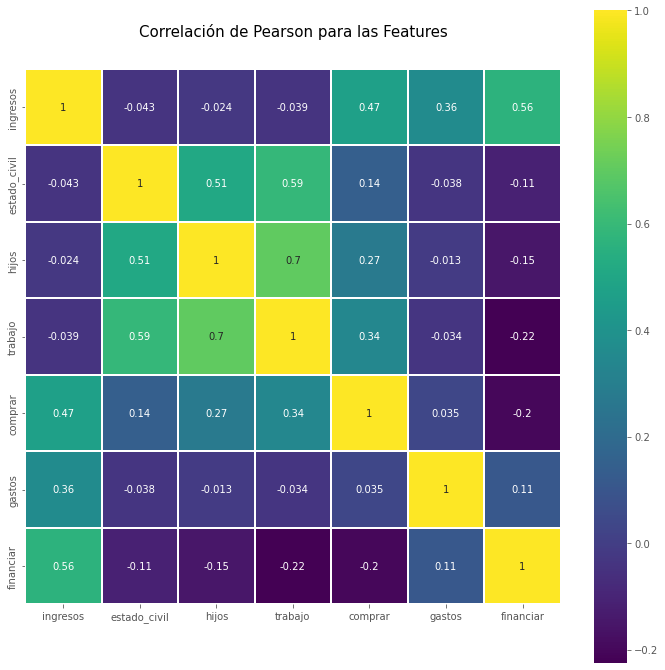

In [44]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Correlación de Pearson para las Features', y=1.05, size=15)
sb.heatmap(reduced.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

El heatmap presenta que en general los feature se encuentran poco correlacionados, por lo que la independencia se "cumpliría", excepto por dos que se encuentran en el rango de 0,7.

Ahora podemos hacer uso de esta información y generar nuestro algoritmo de clasificación. 

Primero dividimos las bases de datos, dejando 20% en test y 80% en train.

In [45]:
#reduced.drop(['ahorros','vivienda'], axis=1, inplace=True)

In [46]:

X_train, X_test = train_test_split(reduced, test_size=0.2, random_state=6) 
y_train =X_train["comprar"]
y_test = X_test["comprar"]
X_train.drop(["comprar"], axis=1)
X_test.drop(["comprar"], axis=1)

,ingresos,estado_civil,hijos,trabajo,gastos,financiar
120,5730,1,2,6,1493,548201
11,5058,2,0,2,1549,375498
104,5552,2,2,8,1901,333896
179,2028,2,0,3,1182,247675
122,7138,1,2,5,1592,363753
71,4473,1,1,8,2200,257810
94,2448,0,0,4,1432,329800
19,6038,1,1,7,1289,216945
4,6167,0,0,3,1606,307420
6,6830,1,1,5,1952,383051


Y estimamos nuestro modelo. 

In [69]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
# Train classifier
gnb.fit(X_train.values,y_train)
y_pred = gnb.predict(X_test)
 
print('Accuracy en el set de Entrenamiento: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy en el set de Test: {:.2f}'
     .format(gnb.score(X_test, y_test)))


Accuracy en el set de Entrenamiento: 0.89
Accuracy en el set de Test: 0.90


c:\Users\claud\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
c:\Users\claud\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
c:\Users\claud\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


In [71]:
report_nb = classification_report(y_test, y_pred, target_names=["arrendar", "vender"])
print(report_nb)

              precision    recall  f1-score   support

    arrendar       0.86      1.00      0.92        24
      vender       1.00      0.76      0.87        17

    accuracy                           0.90        41
   macro avg       0.93      0.88      0.89        41
weighted avg       0.92      0.90      0.90        41



Un 90% de precisión parece ser suficiente como para utilizar este modelo al momento de clasificar. Ahora que pasa si incorporamos un nuevos input. 

In [48]:
from sklearn.neighbors import KNeighborsClassifier
knn2=KNeighborsClassifier(n_neighbors=2)
knn2.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=2)

In [49]:
print('Accuracy en el set de Entrenamiento: {:.2f}'
     .format(knn2.score(X_train, y_train)))
print('Accuracy en el set de Test: {:.2f}'
     .format(knn2.score(X_test, y_test)))

Accuracy en el set de Entrenamiento: 0.84
Accuracy en el set de Test: 0.76


### Otro ejemplo

¿Recuerdan los digitos que estabamos utilizando?

Base de datos de pixeles de imagenes de digitos escritos a mano alzada. Cada feature es un pixel y el dominio del problema esta definido a partir de las clases: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9. Para esto vamos a crear un clasificador de 0s, de 1s, ..., de 8s y de 9s.

In [50]:
from sklearn.datasets import load_digits
digits = load_digits()
len(digits.data)

1797

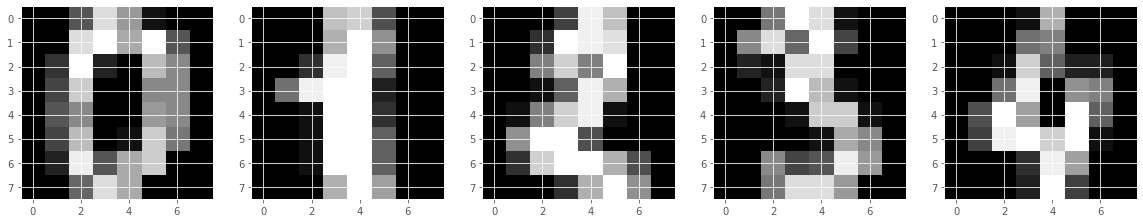

In [51]:
import numpy as np 
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
 plt.subplot(1, 5, index + 1)
 plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)

Vamos a implementar un algoritmo de clasificación Naive Bayes para datos multinomiales. Esto es en el caso de que las feature sean categoricas y el dominio multiclase.

In [52]:
from sklearn.model_selection import train_test_split
x_train_m, x_test_m, y_train_m, y_test_m = train_test_split(digits.data, digits.target, test_size=0.2, random_state=0)

In [66]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()
nb_clf.fit(x_train_m, y_train_m)
predictions_nb = nb_clf.predict(x_test_m)


array([2, 8, 2, 6, 6, 7, 1, 9, 8, 5, 2, 8, 6, 6, 6, 6, 1, 0, 5, 8, 8, 7,
       8, 4, 7, 5, 4, 9, 2, 9, 4, 7, 6, 8, 9, 4, 3, 1, 0, 1, 8, 6, 7, 7,
       9, 0, 7, 6, 2, 1, 9, 6, 7, 9, 0, 0, 9, 1, 6, 3, 0, 2, 3, 4, 2, 9,
       8, 6, 9, 1, 8, 3, 5, 1, 2, 1, 2, 1, 9, 7, 2, 3, 6, 0, 5, 3, 7, 5,
       1, 2, 9, 9, 3, 1, 7, 7, 4, 8, 5, 8, 5, 5, 2, 5, 9, 0, 7, 2, 4, 7,
       3, 4, 8, 9, 7, 7, 8, 0, 6, 9, 2, 5, 8, 4, 1, 7, 0, 6, 1, 5, 9, 9,
       9, 5, 9, 9, 5, 7, 5, 6, 2, 8, 6, 7, 6, 1, 5, 1, 5, 9, 9, 1, 9, 3,
       6, 1, 8, 9, 7, 7, 6, 7, 6, 5, 6, 0, 8, 8, 9, 8, 6, 1, 0, 4, 2, 6,
       3, 8, 6, 7, 4, 9, 6, 3, 0, 9, 3, 3, 0, 7, 7, 9, 7, 8, 0, 7, 8, 9,
       6, 4, 5, 0, 1, 4, 6, 4, 3, 3, 0, 9, 5, 9, 2, 9, 4, 1, 1, 6, 8, 9,
       2, 4, 9, 3, 7, 6, 2, 3, 3, 1, 6, 9, 3, 6, 3, 9, 2, 0, 7, 6, 1, 1,
       9, 7, 2, 7, 1, 5, 5, 7, 5, 2, 2, 7, 2, 7, 9, 5, 7, 0, 9, 1, 6, 5,
       9, 7, 4, 3, 8, 0, 3, 6, 4, 6, 3, 2, 6, 8, 8, 8, 4, 6, 7, 5, 2, 4,
       5, 3, 2, 4, 6, 9, 4, 5, 4, 3, 4, 6, 2, 9, 0,

Y ahora evaluemos la precición del modelo.

In [54]:
report_nb = classification_report(y_test_m, predictions_nb, target_names=["class_0", "class_1", "class_2", "class_3", "class_4", "class_5", "class_6", "class_7", "class_8", "class_9"])
print(report_nb)

              precision    recall  f1-score   support

     class_0       0.96      1.00      0.98        27
     class_1       0.83      0.71      0.77        35
     class_2       0.82      0.86      0.84        36
     class_3       1.00      0.90      0.95        29
     class_4       1.00      0.97      0.98        30
     class_5       0.97      0.85      0.91        40
     class_6       1.00      1.00      1.00        44
     class_7       0.89      1.00      0.94        39
     class_8       0.92      0.90      0.91        39
     class_9       0.77      0.90      0.83        41

    accuracy                           0.91       360
   macro avg       0.92      0.91      0.91       360
weighted avg       0.91      0.91      0.91       360



Ahora, en la primera clase vimos los resultados para este ejemplo con regresión logística. ¿Con qué modelo me quedó si tuvieramos que elegir entre Nave Bayes y Regresión Logística?

Vamos a correr la regresión logistica nuevamente. 

In [68]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train_m, y_train_m)
predictions_logit = logisticRegr.predict(x_test_m)



c:\Users\claud\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Y reportemos las metricas de rendimiento del modelo. 

In [56]:
report_log = classification_report(y_test_m, predictions_logit, target_names=["class_0", "class_1", "class_2", "class_3", "class_4", "class_5", "class_6", "class_7", "class_8", "class_9"])
print(report_log)

              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        27
     class_1       0.92      0.97      0.94        35
     class_2       0.97      0.97      0.97        36
     class_3       0.97      1.00      0.98        29
     class_4       0.97      0.97      0.97        30
     class_5       0.97      0.93      0.95        40
     class_6       1.00      0.98      0.99        44
     class_7       0.97      0.97      0.97        39
     class_8       0.97      0.92      0.95        39
     class_9       0.93      0.98      0.95        41

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



¿Con cuál se quedarían ustedes y porqué?

### Ejemplo KNN 

Ahora veremos un ejemplo simulado de KNN.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
from sklearn.datasets import make_blobs
datos=make_blobs(n_samples=3500,n_features=5, centers=2, cluster_std=6, random_state=101)
datos_names=pd.DataFrame(datos[0], columns=["features_"+str(i) for i in range(1,6)])
datos_names.head(2)

,features_1,features_2,features_3,features_4,features_5
0,20.943994,-3.461489,3.878203,8.755618,-3.035475
1,13.136404,-14.952887,11.816829,12.038842,-7.960440


In [59]:
y=datos[1]
y

array([1, 1, 1, ..., 1, 1, 1])

In [60]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X=scaler.fit_transform(datos_names)
X

array([[0.80531784, 0.47110676, 0.57930226, 0.6220055 , 0.47470305],
       [0.64514763, 0.2104523 , 0.71563843, 0.68223265, 0.38016573],
       [0.3915503 , 0.47273612, 0.5206978 , 0.40252366, 0.28579459],
       ...,
       [0.5662594 , 0.43351891, 0.91185858, 0.59835162, 0.49592814],
       [0.54659497, 0.52441064, 0.52761973, 0.57353642, 0.47513524],
       [0.44867686, 0.44142069, 0.60874446, 0.76011493, 0.41836792]])

In [61]:
from sklearn.model_selection import train_test_split
X_train_knn, X_test_knn, y_train_knn, y_test_knn=train_test_split(X,y,test_size=0.3,random_state=101)

In [62]:
from sklearn.neighbors import KNeighborsClassifier
knn2=KNeighborsClassifier(n_neighbors=2)
knn2.fit(X_train_knn,y_train_knn)

KNeighborsClassifier(n_neighbors=2)

In [63]:
prediction2=knn2.predict(X_test_knn)
print(classification_report(y_test_knn,prediction2))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       545
           1       0.99      0.95      0.97       505

    accuracy                           0.97      1050
   macro avg       0.97      0.97      0.97      1050
weighted avg       0.97      0.97      0.97      1050



In [64]:
from sklearn.neighbors import KNeighborsClassifier
knn20=KNeighborsClassifier(n_neighbors=3)
knn20.fit(X_train_knn,y_train_knn)

KNeighborsClassifier(n_neighbors=3)

In [65]:
prediction20=knn20.predict(X_test_knn)
print(classification_report(y_test_knn,prediction20))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       545
           1       0.98      0.98      0.98       505

    accuracy                           0.98      1050
   macro avg       0.98      0.98      0.98      1050
weighted avg       0.98      0.98      0.98      1050

